#Import packages

In [ ]:
# run this cell to install pycaret in Google Colab
# !pip3 install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 5.2 MB/s 
     |████████████████████████████████| 10.4 MB 3.1 MB/s 
     |████████████████████████████████| 25.9 MB 80.7 MB/s 
     |████████████████████████████████| 17.0 MB 203 kB/s 
     |████████████████████████████████| 636 kB 67.0 MB/s 
     |████████████████████████████████| 1.3 MB 58.6 MB/s 
     |████████████████████████████████| 262 kB 62.0 MB/s 
     |████████████████████████████████| 6.8 MB 35.7 MB/s 
     |████████████████████████████████| 88 kB 7.6 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 134 kB 47.0 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
     |████████████████████████████████| 1.7 MB 60.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel 

In [ ]:
# pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [ ]:
import jinja2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from pycaret.regression import *

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, precision_score, recall_score

# Mount Google Drive and define path to data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the path to your drive or skip first line if running locally
%cd '/content/drive/MyDrive/ZEIS/Task2/Code'

path_to_na_handled_data = './data/no_missing_values/Bias_correction_ucl_without_na.csv'

# For saving later
path_to_training_x = './data/preprocessed/training/training_x.csv'
path_to_training_y = './data/preprocessed/training/training_y.csv'
path_to_test_x = './data/preprocessed/test/test_x.csv'
path_to_test_y = './data/preprocessed/test/test_y.csv'

/content/drive/MyDrive/ZEIS/Task2/Code


# Read data set

In [ ]:
# Load the csv file
df = pd.read_csv(path_to_na_handled_data)

# Show data size
print(df.shape)

# Show first 5 rows
df.head()

(7725, 26)


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,30.0,6.0
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,30.0,6.0
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9,30.0,6.0
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,30.0,6.0
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,30.0,6.0


In [ ]:
# add new vars of interest
df['Shifted_Tmax'] = df.groupby(['station'])['Present_Tmax'].shift(-1)
df['Original_Model_Tmax'] = df.groupby(['station'])['Next_Tmax'].shift(-1)
df['Original_Model_Tmin'] = df.groupby(['station'])['Next_Tmin'].shift(-1)
df = df[~df.Shifted_Tmax.isnull()]

# Data set split

Perform random training (80%) and test (20%) set  split.

In [ ]:
training = df.sample(frac=0.8, random_state=42)
test = df.drop(training.index)

training.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


print('Training data: ' + str(training.shape))
print('Test data: ' + str(test.shape))

Training data: (6159, 29)
Test data: (1540, 29)


In [ ]:
# Show training x data size
print(training.shape)

# Show first 5 rows
training.head()

(6159, 29)


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Shifted_Tmax,Original_Model_Tmax,Original_Model_Tmin
0,21.0,23.9,19.8,82.235489,89.673126,20.718329,16.868849,14.908830,86.993173,0.759186,0.862202,0.898900,0.723556,0.348464,2.153618,5.217196,1.139555,37.5507,127.040,26.298,0.5721,4416.057129,21.0,16.8,30.0,8.0,29.769563,30.0,23.4
1,11.0,33.3,23.6,66.820587,87.265312,27.686557,23.297818,7.649986,46.474749,0.075526,0.371413,0.537159,0.477840,0.000000,0.000000,0.000000,0.000000,37.5372,127.085,28.700,0.6233,5773.572754,29.6,23.3,11.0,7.0,29.200000,29.9,23.9
2,21.0,31.4,26.8,47.470783,73.772690,32.045772,26.187135,5.987530,11.862159,0.456465,0.360947,0.264195,0.065959,0.000000,0.000000,0.000000,0.000000,37.5507,127.040,26.298,0.5721,4686.240234,32.8,26.7,23.0,8.0,32.200000,32.5,24.3
3,7.0,35.1,26.1,84.941071,96.162003,27.492850,24.291214,6.134591,80.845937,0.531375,0.774828,0.722975,0.362628,2.137596,2.036293,0.122409,0.000000,37.5776,126.838,12.370,0.0985,5225.844238,33.5,24.1,7.0,8.0,33.400000,30.8,24.1
4,7.0,26.2,21.2,42.155598,91.796249,26.390127,20.363067,7.683484,117.269838,0.013075,0.334821,0.080050,0.006082,0.000000,0.009160,0.077598,0.000000,37.5776,126.838,12.370,0.0985,5843.853516,28.0,20.5,1.0,7.0,27.500000,26.6,19.3


In [ ]:
# Show test x data size
print(test.shape)

# Show first 5 rows
test.head()

(1540, 29)


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Shifted_Tmax,Original_Model_Tmax,Original_Model_Tmin
0,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,30.0,6.0,31.0,27.9,21.5
1,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,30.0,6.0,30.8,28.2,22.2
2,6.0,31.9,23.5,52.437126,85.307251,29.219342,23.822613,6.182295,50.231389,0.185279,0.280818,0.232841,0.146363,0.0,0.0,0.0,0.0,37.5102,127.042,54.6384,0.1457,5873.780762,31.5,24.0,30.0,6.0,31.0,28.9,22.3
3,10.0,31.6,20.5,56.651203,86.849632,27.576705,22.527018,6.518841,63.006075,0.348292,0.306255,0.245254,0.135443,0.0,0.0,0.0,0.0,37.4562,126.955,208.5070,5.1782,5893.608398,30.5,21.0,30.0,6.0,30.0,27.5,20.7
4,17.0,32.1,20.1,54.352501,93.218315,29.321525,23.036163,5.497787,97.971438,0.151998,0.236199,0.195431,0.149973,0.0,0.0,0.0,0.0,37.6181,127.099,53.4712,0.6970,5872.376465,31.5,21.1,30.0,6.0,30.6,27.8,21.7


Save splitted data sets.

In [ ]:
# x_train.to_csv('./data/preprocessed/training/training_x.csv', index=False)
# y_train.to_csv('./data/preprocessed/training/training_y.csv', index=False)
# x_test.to_csv('./data/preprocessed/test/test_x.csv', index=False)
# y_test.to_csv('./data/preprocessed/test/test_y.csv', index=False)

# Training

We will use pycaret library as it has many pre-designed features in the modeling process.

We are excluding the results in ['Next_Tmax', 'Next_Tmin'], since we are going to use these numbers to measure some of our metrics.

We are also including polynomial and trigonometric features, which are generated from the relationship between different preexisting features (e.g., the multiplication of two features, the tangent of one another).

Finally, the "feature_selection" parameter will use tree-based models to verify which features have better predictive power in relation to the target, excluding the others. In order to reduce the number of features (expanded by the parameterization of polynomials and trigonometrics) and prevent some features from having a negative impact on the result.

In [ ]:
exp_reg101 = setup(
    data = training, 
    target = 'Shifted_Tmax', 
    fold_shuffle=True, 
    imputation_type='iterative', 
    ignore_features=['Next_Tmax', 'Next_Tmin', 'Original_Model_Tmax', 'Original_Model_Tmin'], 
    polynomial_features=True, 
    trigonometry_features=True, 
    feature_selection=True
)

,Description,Value
0,session_id,7743
1,Target,Shifted_Tmax
2,Original Data,"(6159, 29)"
3,Missing Values,False
4,Numeric Features,24
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4311, 34)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['Next_Tmax', 'Next_Tmin',
                                                       'Original_Model_Tmax',
                                                       'Original_Model_Tmin'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Shifted_Tmax',
                                      time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=False,
                                   classifier=L...
                ('fix_perfect', Remove_100(target='Shifted_Tmax')),
                ('

# Resulting Features

The table below presents the resulting features that will be used to train the predictive model.

In [ ]:
pd.options.display.max_columns = 100
xt = get_config('X_train')
xt

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as       LDAPS_PPT3  LDAPS_PPT2  cos(Day)  LDAPS_PPT1  Month  tan(LDAPS_CC3)  \
2347    0.003665    0.062325  0.753902    0.006854    7.0        0.788599   
2806    0.114325    0.001704 -0.911130    0.000000    8.0        0.781167   
4807    0.000000    0.009633 -0.911130    2.250124    7.0        0.410810   
774     0.000000    0.000000  0.843854    0.000000    8.0        0.033333   
5879    0.000000    0.000000  0.660317    0.000000    8.0        0.625074   
...          ...         ...       ...         ...    ...             ...   
3267    0.405181    0.000000 -0.292139    0.181458    8.0        0.486610   
1203    0.000000    0.085961  0.136737    3.231834    7.0        0.521816   
2965    0.000000    0.000000 -0.145500    0.004252    7.0        0.502188   
1475    0.000000    0.009754  0.283662    0.000000    8.0        0.093522   
2914    0.000000    1.038765 -0

,LDAPS_PPT3,LDAPS_PPT2,cos(Day),LDAPS_PPT1,Month,tan(LDAPS_CC3),Solar radiation_Power2,Slope,LDAPS_Tmax_lapse,station,LDAPS_PPT4,Present_Tmin_Power2,LDAPS_CC3,DEM,LDAPS_WS_Power2,LDAPS_CC4_Power2,LDAPS_Tmin_lapse_Power2,LDAPS_CC1,Day_Power2,LDAPS_RHmin,tan(Day),lat,tan(LDAPS_CC2),LDAPS_RHmin_Power2,lon,LDAPS_LH,LDAPS_CC4,Present_Tmax,LDAPS_CC3_Power2,LDAPS_RHmax,LDAPS_WS,LDAPS_CC2_Power2,LDAPS_CC2,Day
2347,0.003665,0.062325,0.753902,0.006854,7.0,0.788599,33955680.0,0.4125,26.903767,9.0,0.013308,428.490021,0.667751,50.931198,146.710144,4.223991e-01,574.895874,0.698052,49.0,80.862701,0.871448,37.496700,1.137215,6538.776367,126.825996,40.097191,0.649922,27.700001,0.445891,93.315285,12.112396,0.721672,0.849513,7.0
2806,0.114325,0.001704,-0.911130,0.000000,8.0,0.781167,26568498.0,2.2579,27.629995,16.0,0.291617,470.890045,0.663152,82.291199,61.667305,2.220426e-01,476.980347,0.348360,81.0,59.790348,-0.452316,37.469700,0.454081,3574.885742,126.995003,65.992805,0.471214,29.700001,0.439770,91.795570,7.852853,0.181683,0.426243,9.0
4807,0.000000,0.009633,-0.911130,2.250124,7.0,0.410810,33640448.0,0.5141,30.262762,2.0,0.000000,538.240051,0.389791,44.762402,79.664597,1.245389e-01,579.983459,0.882093,81.0,60.993160,-0.452316,37.604599,0.750868,3720.165527,127.031998,46.439510,0.352901,26.900000,0.151937,97.508919,8.925503,0.414809,0.644056,9.0
774,0.000000,0.000000,0.843854,0.000000,8.0,0.033333,25628126.0,2.2579,32.484352,16.0,0.000000,585.640015,0.033321,82.291199,36.931900,2.025000e-09,698.109619,0.081552,144.0,48.546322,-0.635860,37.469700,0.116543,2356.745361,126.995003,104.903664,0.000045,32.099998,0.001110,85.685989,6.077162,0.013461,0.116020,12.0
5879,0.000000,0.000000,0.660317,0.000000,8.0,0.625074,24179074.0,0.5931,31.770596,12.0,0.000000,630.010010,0.558652,132.117996,37.946163,3.630268e-01,736.148193,0.198010,324.0,53.118893,-1.137314,37.550701,0.285805,2821.616699,126.987999,18.423779,0.602517,33.599998,0.312093,73.021370,6.160046,0.077497,0.278383,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,0.405181,0.000000,-0.292139,0.181458,8.0,0.486610,20608120.0,0.6970,23.529545,17.0,1.015573,127.690002,0.452879,53.471199,63.753296,3.934270e-01,322.686890,0.668264,729.0,62.793823,-3.273704,37.618099,0.435269,3943.064209,127.098999,84.481453,0.627238,27.100000,0.205099,91.726936,7.984566,0.168540,0.410536,27.0
1203,0.000000,0.085961,0.136737,3.231834,7.0,0.521816,32794402.0,2.2579,29.332977,16.0,0.000000,576.000000,0.480948,82.291199,60.970078,9.112916e-02,558.017090,0.715894,196.0,73.124138,7.244606,37.469700,0.604349,5347.139648,126.995003,80.880936,0.301876,31.799999,0.231311,92.309273,7.808334,0.295513,0.543611,14.0
2965,0.000000,0.000000,-0.145500,0.004252,7.0,0.502188,33681548.0,1.5629,27.730663,8.0,0.000000,453.689972,0.465396,52.518002,43.785706,2.738495e-02,498.268127,0.629655,64.0,56.211494,-6.799711,37.469700,0.862129,3159.732178,126.910004,30.170872,0.165484,25.600000,0.216594,72.446777,6.617077,0.506223,0.711493,8.0
1475,0.000000,0.009754,0.283662,0.000000,8.0,0.093522,27910714.0,0.4125,33.491299,9.0,0.000000,681.210022,0.093251,50.931198,29.159311,3.753280e-03,682.315552,0.077651,25.0,52.812199,-3.380515,37.496700,0.012534,2789.128418,126.825996,115.774353,0.061264,35.500000,0.008696,87.425056,5.399936,0.000157,0.012533,5.0


# Best Models

In [ ]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6553,0.7760,0.8787,0.9124,0.0292,0.0224,0.408
et,Extra Trees Regressor,0.6542,0.8118,0.8974,0.9086,0.0297,0.0223,2.364
rf,Random Forest Regressor,0.7393,1.0083,1.0017,0.8862,0.0333,0.0252,6.076
gbr,Gradient Boosting Regressor,0.8915,1.3904,1.1762,0.8432,0.0391,0.0305,2.478
ada,AdaBoost Regressor,1.2121,2.2678,1.5040,0.7439,0.0503,0.0417,0.842
dt,Decision Tree Regressor,1.0866,2.2857,1.5086,0.7418,0.0500,0.0370,0.108
ridge,Ridge Regression,1.1310,2.3726,1.5334,0.7329,0.0514,0.0388,0.016
br,Bayesian Ridge,1.1316,2.3915,1.5391,0.7308,0.0517,0.0388,0.022
lr,Linear Regression,1.1867,2.6130,1.6079,0.7061,0.0543,0.0408,0.330
omp,Orthogonal Matching Pursuit,1.2325,2.7710,1.6570,0.6883,0.0558,0.0423,0.016


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:[LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7743, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
              

# Stacking top 3 models

In [ ]:
stacker1 = stack_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5788,0.7047,0.8395,0.9229,0.0282,0.0194
1,0.5529,0.5295,0.7277,0.9360,0.0242,0.0188
2,0.6249,0.6801,0.8247,0.9202,0.0272,0.0212
3,0.5628,0.5526,0.7434,0.9346,0.0248,0.0193
4,0.5775,0.5740,0.7577,0.9399,0.0247,0.0195
5,0.5811,0.6409,0.8006,0.9193,0.0263,0.0198
6,0.5755,0.5493,0.7412,0.9384,0.0242,0.0194
7,0.6006,0.6556,0.8097,0.9261,0.0272,0.0207
8,0.6348,1.0077,1.0039,0.8933,0.0327,0.0214


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:StackingRegressor(cv=5,
                  estimators=[('lightgbm',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=7743, reg_alpha=0.0,
                                          

In [ ]:
model = finalize_model(stacker1)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=StackingRegressor(cv=5,
                  estimators=[('lightgbm',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=7743, reg_alpha=0.0,
                                             reg_lambda=0.0, silent='...
         

# Visualize results

Show top 3 model results as well as ensemble model accuracy & error.

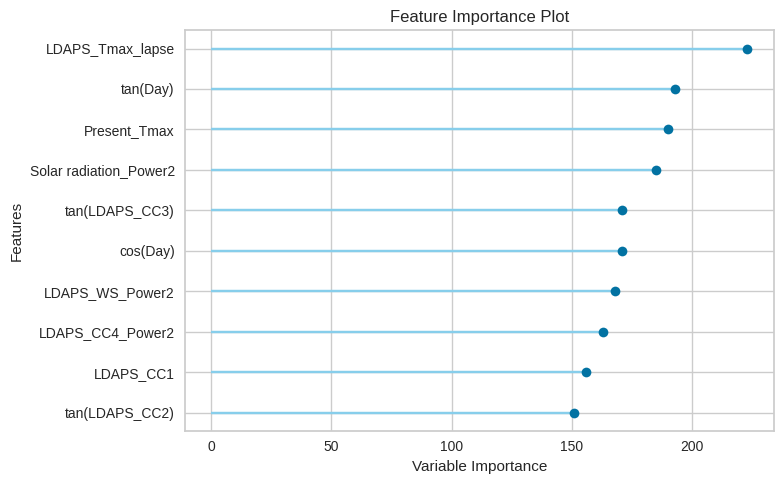

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[0], plot='feature')

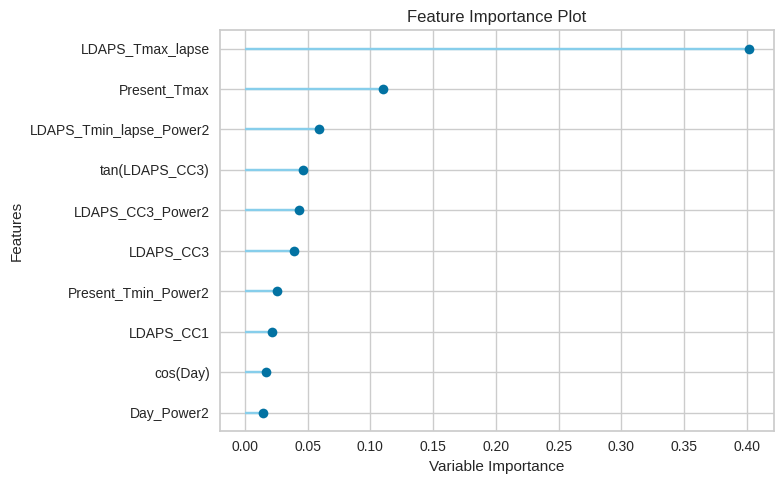

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[1], plot='feature')

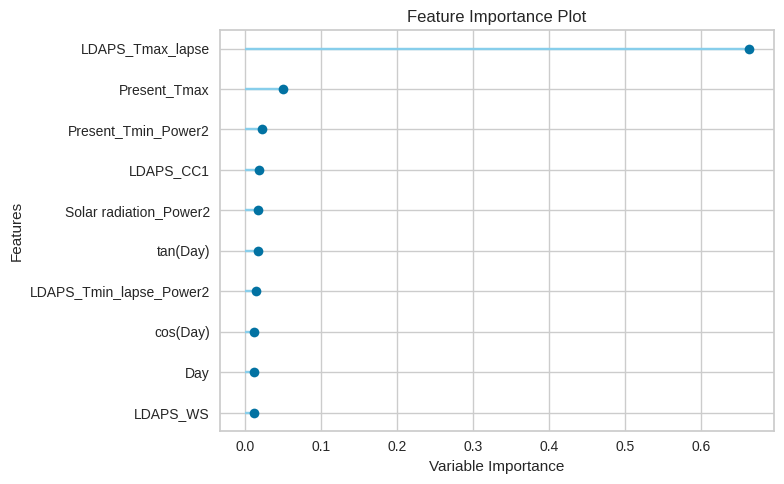

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[2], plot='feature')

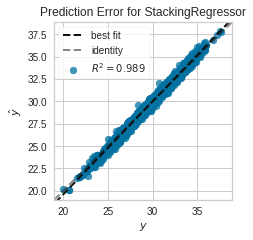

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(model, plot='error')

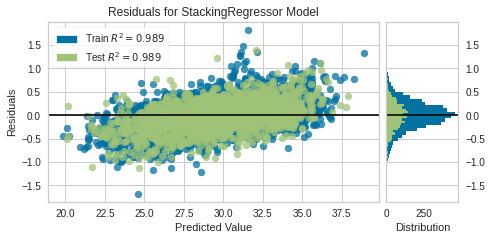

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(model, plot='residuals')

# Test

In [ ]:
predictions = predict_model(model, data = test)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=StackingRegressor(cv=5,
                  estimators=[('lightgbm',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=7743, reg_alpha=0.0,
                                             reg_lambda=0.0, silent='...
           

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.5689,0.5896,0.7678,0.9326,0.0252,0.0193


In [ ]:
r2_score(predictions.Shifted_Tmax, predictions.Label)

0.9325848632316024

In [ ]:
mean_squared_error(predictions.Shifted_Tmax, predictions.Label, squared=False)

0.7678439302398894

In [ ]:
predictions['mod_original'] = abs(predictions.Original_Model_Tmax - predictions.Shifted_Tmax)
predictions['mod_label'] = abs(predictions.Label - predictions.Shifted_Tmax)

In [ ]:
(predictions.mod_label < predictions.mod_original).sum() / predictions.shape[0]

0.8409090909090909

In [ ]:
predictions['hotter_true'] = predictions.Shifted_Tmax > predictions.Present_Tmax
predictions['hotter_pred'] = predictions.Label > predictions.Present_Tmax

In [ ]:
confusion_matrix(predictions.hotter_true, predictions.hotter_pred)

array([[680,  90],
       [ 76, 694]])

In [ ]:
precision_score(predictions.hotter_true, predictions.hotter_pred)

0.8852040816326531

In [ ]:
recall_score(predictions.hotter_true, predictions.hotter_pred)

0.9012987012987013

# Save the model

In [ ]:
save_model(model, './models/saved/pycaret_nwp.sav')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=StackingRegressor(cv=5,
                  estimators=[('lightgbm',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=7743, reg_alpha=0.0,
                                             reg_lambda=0.0, silent='...
                     

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Next_Tmax', 'Next_Tmin',
                                                        'Original_Model_Tmax',
                                                        'Original_Model_Tmin'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Shifted_Tmax',
                                       time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=False,
                                    classifier=L...
                                                                       min_impurity_decrease=0.0,
                                                                       min_impurity_spl